In [2]:
pip install ripser

Note: you may need to restart the kernel to use updated packages.


In [3]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

/Users/floyd/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/jvtraplx4to7r5y3zzq4x/collaborations_Mathematical-Physics_105.csv.gz?rlkey=zfwbarxtgk8mm39rq8wz084ma&st=uagb53zy&dl=1',
        compression='gzip',
    )

,article_id,year,researcher_id
0,pub.1058197409,2001,ur.011354531601.87
1,pub.1058197409,2001,ur.011663011361.49
2,pub.1058194732,1981,ur.010165172102.13
3,pub.1058194732,1981,ur.012356227236.62
4,pub.1058194732,1981,ur.014467670703.92
...,...,...,...
693622,pub.1104998165,2018,ur.0732233414.25
693623,pub.1033208781,2002,ur.011170022015.06
693624,pub.1092523788,2017,ur.010122671761.59
693625,pub.1092523788,2017,ur.013642004376.72


In [5]:
pd.read_csv(
        'https://www.dropbox.com/scl/fi/4xf8k1qkqqhf0obgfntug/articles_Mathematical-Physics_105.csv.gz?rlkey=ry94p2lk666900ph12uf4xn4p&st=ujpgk5rh&dl=1',
        compression = 'gzip',
    ).columns

/var/folders/v9/_js75nzx64lf8__fmfsscg4c0000gn/T/ipykernel_19253/1696472445.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


Index(['article_id', 'year', 'date', 'doi', 'volume', 'issue', 'pages',
       'title_preferred', 'abstract_preferred', 'journal_title',
       'citations_count', 'metrics_times_cited', 'metrics_recent_citations',
       'metrics_field_citation_ratio', 'metrics_relative_citation_ratio',
       'altmetrics_score', 'nauthors', 'npatents_citing',
       'ncategory_for_l1_codes', 'ncategory_for_l2_codes',
       'pg_abstract_preferred_lang_code', 'pg_abstract_preferred_lang_conf'],
      dtype='object')

In [6]:
# load the data
df = pd.read_csv(
        'https://www.dropbox.com/scl/fi/bqesm36wl7huyppht9vps/concepts_Pure-Mathematics_101.csv.gz?rlkey=q6ihq3rk3hlimjug24zwnppm0&st=1q0ivoc5&dl=1',
        compression='gzip',
    )

df

,article_id,year,concept,relevance_mean,concept_freq_in_abstract,concept_no,dfreq_in_category_for_2l,dfreq_in_category_for_2l_year
0,pub.1068951934,1989,asme power test code 10,0.0,1,0,1,1
1,pub.1085124332,2017,aposyndetic decomposition theorem,0.0,1,0,7,2
2,pub.1072266757,1981,aposyndetic decomposition theorem,0.0,1,0,7,1
3,pub.1058195248,1984,aramovich aleksandryan,0.0,1,0,1,1
4,pub.1013438559,2000,aske s boys school,0.0,1,0,1,1
...,...,...,...,...,...,...,...,...
28988326,pub.1032700035,1971,′ n ′ tetramethylethylenediamine,0.0,1,31,1,1
28988327,pub.1063112015,1990,′ t j ′′,0.0,1,55,1,1
28988328,pub.1131427052,2020,′ y d,0.0,1,19,1,1
28988329,pub.1063112820,1991,′ j ′′ matrix,0.0,1,41,1,1


In [7]:
# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001

# relevance filtering
df = df[df['relevance_mean'] >= MIN_RELEVANCE]

# year filtering
df = df[df['year'] >= MIN_YEAR]

# counts
num_articles = df['article_id'].nunique()
concept_freq = df.groupby('concept').transform('size') / num_articles
df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]

# remove columns we dont care about
df = df[['article_id', 'concept', 'year']]

df

,article_id,concept,year
17366,pub.1005463738,ads / cft correspondence,1999
17370,pub.1010393758,ads / cft correspondence,2013
17815,pub.1072268549,af algebra,2008
17821,pub.1053660397,af algebra,2005
17823,pub.1044403977,af algebra,1990
...,...,...,...
28952704,pub.1063019963,zeta value,2013
28952717,pub.1011051775,zeta value,2008
28952725,pub.1122622542,zeta value,2019
28952736,pub.1136564106,zeta value,2021


In [8]:
# get the initial publication
concepts = (
        df
            .sort_values('year')  # sort so earliest year is first
            .groupby('concept')
            .agg(
                year=('year', 'min'),
                count=('article_id', 'nunique')
            )
            .reset_index()
    )

# normalize the year
concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)

concepts

,concept,year,count,norm_year
0,abel differential equation,1988,29,0.673267
1,abel equation,1998,36,0.772277
2,abel integral equation,1977,38,0.564356
3,abel – jacobi,2003,27,0.821782
4,abel – jacobi coordinate,1999,25,0.782178
...,...,...,...,...
4873,zakharov – kuznetsov equation,1991,73,0.702970
4874,zero curvature equation,1987,36,0.663366
4875,zero curvature representation,1983,49,0.623762
4876,zero of solution,1956,35,0.356436


In [9]:
# get all possible edges
edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])

# remove duplicates
edges = edges[edges['concept_source'] < edges['concept_target']]  # remove self links (u - u) and the second occurance (u - v vs v - u)
# edges = edges.sort_values('year').drop_duplicates(subset=['concept_source', 'concept_target']).reset_index(drop=True)
edges = edges.groupby(['concept_source', 'concept_target']).agg(
        year=('year', 'min'),
        count=('article_id', 'nunique')
    ).reset_index()

# nromalize the year
edges['norm_year'] = (edges['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)

edges

,concept_source,concept_target,year,count,norm_year
0,abel differential equation,abel equation,2010,5,0.891089
1,abel differential equation,algebraic limit cycle,2010,1,0.891089
2,abel differential equation,bäcklund transformation,2016,1,0.950495
3,abel differential equation,caputo fabrizio fractional derivative,2021,1,1.000000
4,abel differential equation,caputo – fabrizio derivative,2021,1,1.000000
...,...,...,...,...,...
110201,yang – baxter,yang – baxter operator,2012,1,0.910891
110202,yang – baxter algebra,yang – baxter operator,2005,1,0.841584
110203,yang – baxter operator,yetter – drinfeld module,2008,1,0.871287
110204,zakharov – kuznetsov,zakharov – kuznetsov equation,2007,6,0.861386


# Co-occurance statisitc

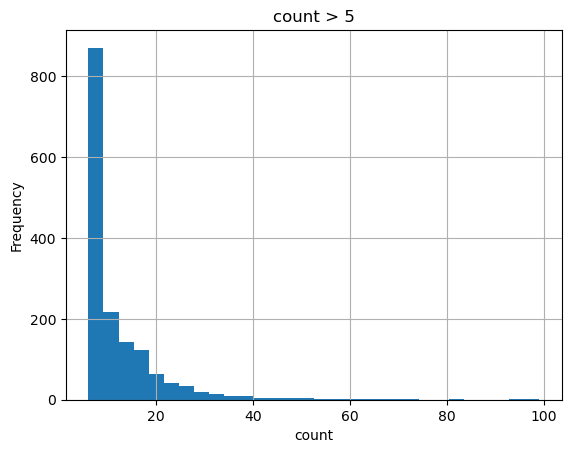

In [10]:
subset = edges[edges['count'] > 5]
subset['count'].hist(bins=30)
plt.xlabel('count')
plt.ylabel('Frequency')
plt.title('count > 5')
plt.show()

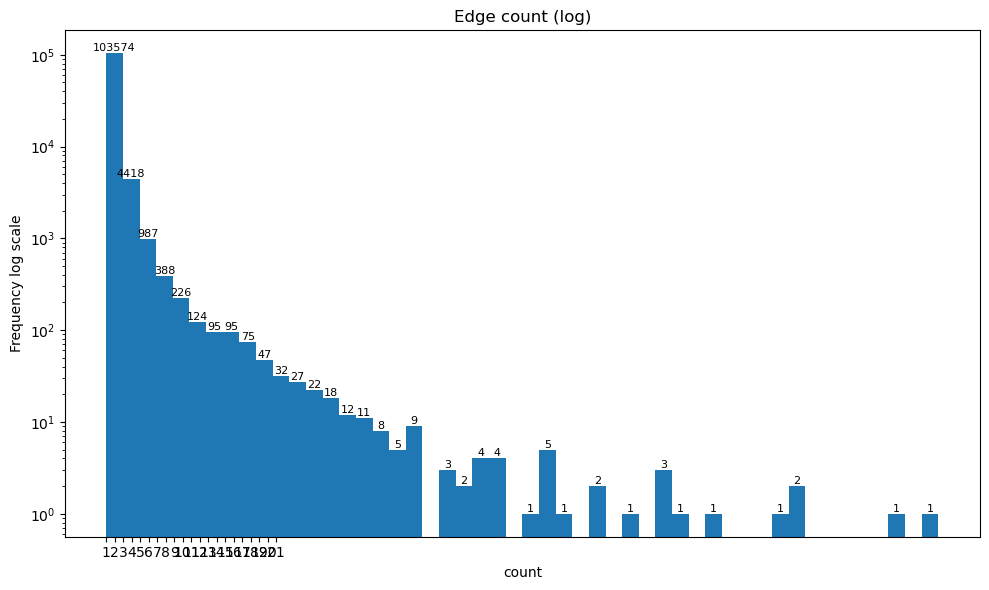

In [11]:
counts, bins = np.histogram(edges['count'], bins=50)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bins[1] - bins[0]))
plt.yscale('log')
plt.xlabel('count')
plt.ylabel('Frequency log scale')
plt.title('Edge count (log)')
for x, y in zip(bin_centers, counts):
    if y > 0:
        plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8)
plt.xticks(np.arange(1, 22, 1))
plt.tight_layout()
plt.show()

In [12]:
import oat_python as oat

In [13]:
def createsubgraph(edges, n):
    edges_single = edges[edges['count'] >= n]
    concepts_used = set(edges_single['concept_source']) | set(edges_single['concept_target'])
    concepts_sub = concepts[concepts['concept'].isin(concepts_used)]

    G_sub = nx.Graph()

    G_sub.add_nodes_from([
        (c, {'norm_year': ny, 'count': ic}) 
        for c, ny, ic in zip(concepts_sub['concept'], concepts_sub['norm_year'], concepts_sub['count'])
    ])

    G_sub.add_edges_from([
        (u, v, {'norm_year': ny, 'count': ic}) 
        for u, v, ny, ic in zip(edges_single['concept_source'], edges_single['concept_target'],
                                edges_single['norm_year'], edges_single['count'])
    ])
    return G_sub

G_sub1 = createsubgraph(edges,1)
G_sub2 = createsubgraph(edges,2)
G_sub3 = createsubgraph(edges,3)
G_sub4 = createsubgraph(edges,4)

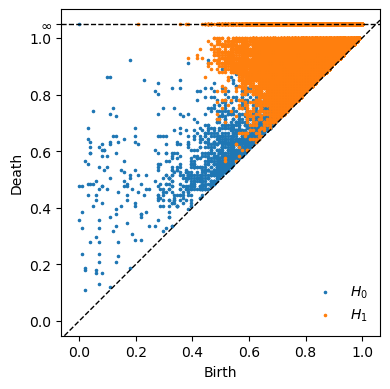

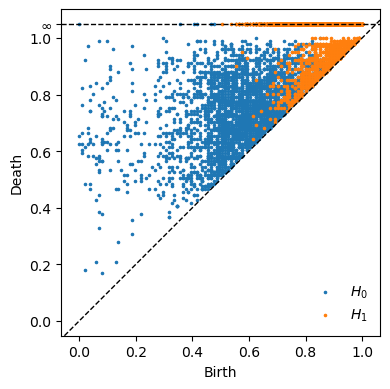

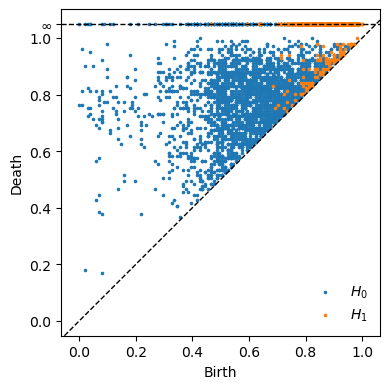

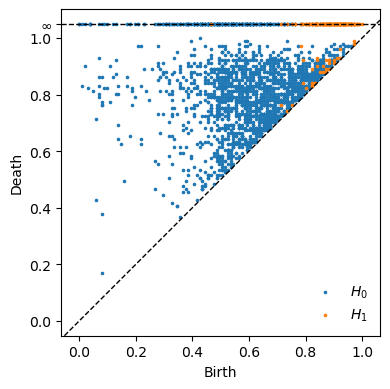

In [14]:
def gethomology(G_sub):
    node_list = list(G_sub.nodes) 
    node_index = {i: node_list[i] for i in range(len(node_list))}   
    reverse_index = {v: k for k, v in node_index.items()}           

    adj = nx.adjacency_matrix(G_sub, nodelist=node_list, weight='norm_year')
    adj.setdiag([G_sub.nodes[n]['norm_year'] for n in node_list])
    adj = adj.sorted_indices()

    factored = oat.rust.FactoredBoundaryMatrixVr(adj, 1)
    homology = factored.homology(
        return_cycle_representatives=True,
        return_bounding_chains=True
    )

    return homology, node_index 

def draw_persistent_diag(G_sub):
    homology,node = gethomology(G_sub)
    # initialize the plot
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(4)
    infty = 1.05
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.axis('equal')

    # lines
    ax.axhline(infty, ls='--', c='k', lw=1)
    ax.axline([0, 0], [1, 1], ls='--', c='k', lw=1)

    # loop, plot homology
    for dim in homology['dimension'].unique():
        dim_bc = homology[homology['dimension'] == dim]
        ax.scatter(dim_bc['birth'], dim_bc['death'].replace(np.inf, infty), s=2.5, label=f'$H_{dim}$')

    # final formatting
    ticks = ax.get_yticklabels()[1:-1]
    ticks.append(Text(0, infty, r'$\infty$'))  # add infty label
    ax.set_yticks(np.hstack((ax.get_yticks()[1:-1], infty)))
    ax.set_yticklabels(ticks)
    ax.legend(frameon=False)
    fig.tight_layout()

draw_persistent_diag(G_sub1)
draw_persistent_diag(G_sub2)
draw_persistent_diag(G_sub3)
draw_persistent_diag(G_sub4)

In [15]:
import ast
import re

In [ ]:
df_homology1 = gethomology(G_sub1)
df_homology2 = gethomology(G_sub2)
df_homology3 = gethomology(G_sub3)
df_homology4 = gethomology(G_sub4)

def picklargestcycle(df_homology, node_index, max_filtration_val=1.05):
    df_H1 = df_homology[df_homology['dimension'] == 1].copy()
    df_H1['death_mod'] = df_H1['death'].replace(np.inf, max_filtration_val)
    df_H1['persistence'] = df_H1['death_mod'] - df_H1['birth']

    df_H1_sorted = df_H1.sort_values(by=['persistence', 'birth'], ascending=[False, True])
    target_bar = df_H1_sorted.iloc[0]
    print(f"Selected bar: birth={target_bar['birth']}, death={target_bar['death']}, persistence={target_bar['persistence']}")

    pattern_all = r"\[([0-9,\s]+)\]"
    matches = re.findall(pattern_all, str(target_bar['cycle representative']))

    edge_list = []
    for m in matches:
        local_nodes = list(map(int, m.strip().split(',')))
        real_nodes = [node_index[i] for i in local_nodes]
        if len(real_nodes) == 2:
            edge_list.append(tuple(real_nodes))
        elif len(real_nodes) > 2:
            edge_list.extend([(real_nodes[i], real_nodes[(i+1)%len(real_nodes)]) for i in range(len(real_nodes))])

    node_set = set([n for edge in edge_list for n in edge])
    print("Nodes involved in generator:", node_set)
    print("Edges:", edge_list)

    return node_set, edge_list

Selected bar: birth=0.2079207920792079, death=inf, persistence=0.8420792079207922
Nodes involved in generator: {'london mathematical society', 'algebraic theory', 'non commutative algebra', 'theory of number', 'branch of mathematic', 'theory of equation', 'function theory'}
Edges: [('algebraic theory', 'theory of equation'), ('algebraic theory', 'non commutative algebra'), ('branch of mathematic', 'theory of number'), ('theory of equation', 'theory of number'), ('function theory', 'non commutative algebra'), ('function theory', 'london mathematical society'), ('branch of mathematic', 'london mathematical society')]


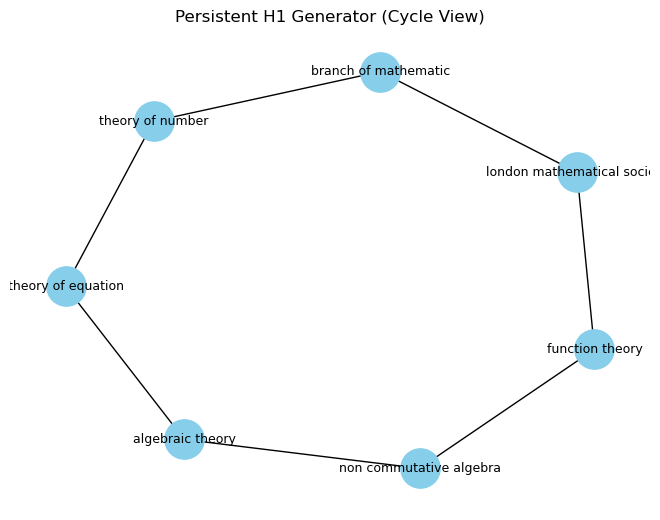

Selected bar: birth=0.504950495049505, death=inf, persistence=0.5450495049504951
Nodes involved in generator: {'probability density', 'fokker planck', 'classical statistical mechanic', 'kinetic equation', 'classical mechanic', 'distribution function'}
Edges: [('fokker planck', 'kinetic equation'), ('classical statistical mechanic', 'distribution function'), ('distribution function', 'kinetic equation'), ('fokker planck', 'probability density'), ('classical mechanic', 'probability density'), ('classical mechanic', 'classical statistical mechanic')]


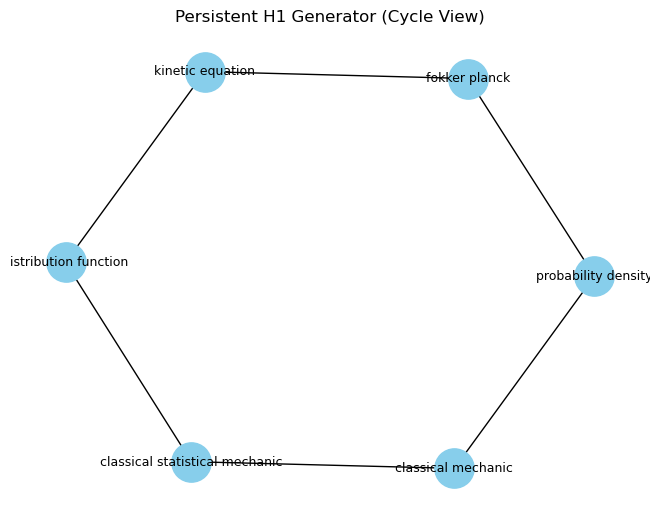

Selected bar: birth=0.46534653465346537, death=inf, persistence=0.5846534653465347
Nodes involved in generator: {'algebraic number field', 'algebraic function field', 'function field', 'class field theory'}
Edges: [('algebraic function field', 'function field'), ('algebraic function field', 'algebraic number field'), ('algebraic number field', 'class field theory'), ('class field theory', 'function field')]


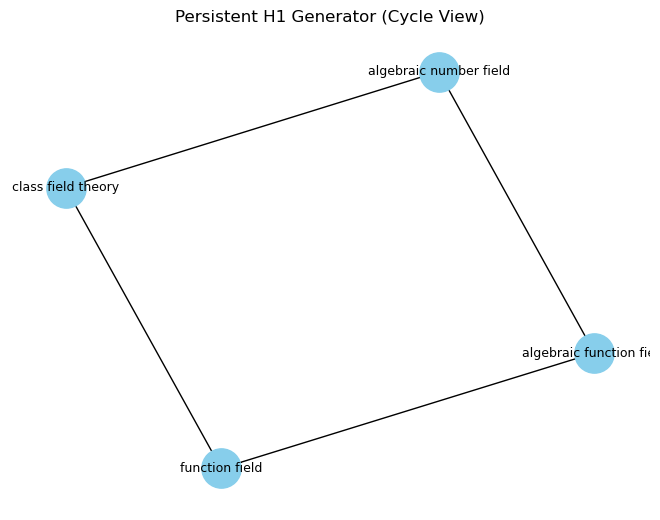

Selected bar: birth=0.46534653465346537, death=inf, persistence=0.5846534653465347
Nodes involved in generator: {'algebraic number field', 'algebraic function field', 'function field', 'class field theory'}
Edges: [('algebraic function field', 'function field'), ('algebraic function field', 'algebraic number field'), ('algebraic number field', 'class field theory'), ('class field theory', 'function field')]


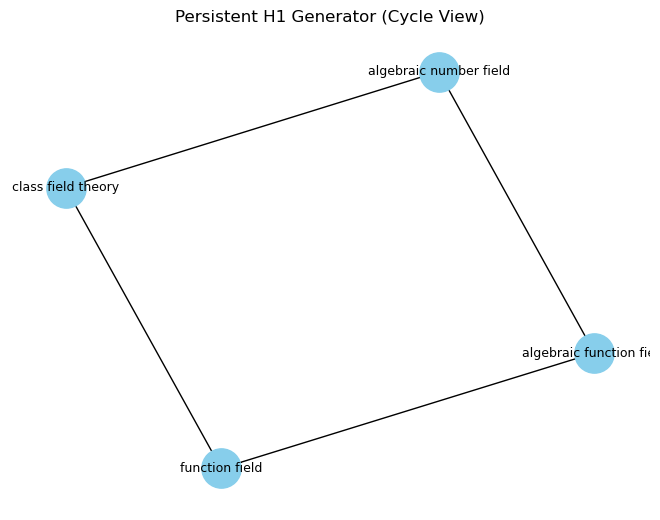

In [18]:
def drawlargecycle(df_homology, node_index, G_sub, max_filtration_val=1.05, show_labels=True):
    node_set, edge_list = picklargestcycle(df_homology, node_index, max_filtration_val)
    H = nx.Graph()
    H.add_nodes_from(node_set)
    H.add_edges_from(edge_list)
    pos = nx.spring_layout(H, seed=42)

    if show_labels:
        labels = {
            n: G_sub.nodes[n]['label'] if 'label' in G_sub.nodes[n] else str(n)
            for n in H.nodes
        }
    else:
        labels = None
    nx.draw(H, pos, with_labels=show_labels, labels=labels,
            node_color='skyblue', node_size=800, font_size=9)
    
    plt.title("Persistent H1 Generator (Cycle View)")
    plt.axis('off')
    plt.show()

df_homology1, node_index1 = gethomology(G_sub1)
df_homology2, node_index2 = gethomology(G_sub2)
df_homology3, node_index3 = gethomology(G_sub3)
df_homology4, node_index4 = gethomology(G_sub4)
drawlargecycle(df_homology1, node_index1, G_sub1)
drawlargecycle(df_homology2, node_index2, G_sub2)
drawlargecycle(df_homology3, node_index3, G_sub3)
drawlargecycle(df_homology4, node_index4, G_sub4)